# SLSFS Paper Experiment Analysis

In [78]:
import pandas as pd
import numpy as np
import os
import random
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

# Place the report csv file inside the exp-reports folder and specify the file name to read a report

In [88]:
def read_report(report_name):
    df = pd.read_csv(report_name)    
    
    df['bytes'] = df['bytes'].apply(lambda x: x * 0.001)
#     df['duration_us'] = df['duration_us'].apply(lambda x: x * 0.001)
    df = df.rename(columns={"bytes":"Kb", "duration_us":"Duration (microseconds)"})
    
    df_read = df[df["access_type"] == "read"]
    df_write = df[df["access_type"] == "write"]
    
    return df, df_read, df_write

#### SLSFS SSBS BASIC tested with test trace
Total IO operations = 994
IOPS = 90
Runtime = 11

In [36]:
df_sls_ssbd_basic, df_sls_ssbd_basic_read, df_sls_ssbd_basic_write = read_report("slsfs-ssbd-basic.csv")

In [110]:
df_sls_r_below_1s, df_sls_r_below_1s_read, df_sls_r_below_1s_write = read_report("report-slsfs-r-below-1s.csv")

In [40]:
df_sls_j2alqt8s, df_sls_j2alqt8s_read, df_sls_j2alqt8s_write =  read_report("report_j2alqt8s.csv")

In [297]:
df_ceph_direct, df_ceph_direct_read, df_ceph_direct_write = read_report("ceph_o_direct.csv")

In [213]:
df_ceph_0insggn2, df_ceph_0insggn2_read, df_ceph_0insggn2_write = read_report("report_ceph_0insggn2.csv")

In [12]:
df_caching, df_caching_read, df_caching_write = read_report("caching-reports/report-66-caching.csv")

In [20]:
df_no_caching, df_no_caching_read, df_no_caching_write = read_report("caching-reports/report-66-nocaching.csv")

## CEPH (O-direct)


### READ

Number of accesses = 254

Average Throughput = 1.0323103622047243 mb/s
Average access duration = 13.79882283464567 ms
Average access size = 19.38848818897638 Kb

Median Throughput = 0.0568405 mb/s
Median access duration = 8.996 ms
Median access size = 0.446 Kb

IQR Throughput = 0.886586 mb/s
IQR access duration = 7.1377500000000005 ms
IQR access size = 11.14425 Kb



(0.0, 50.0)

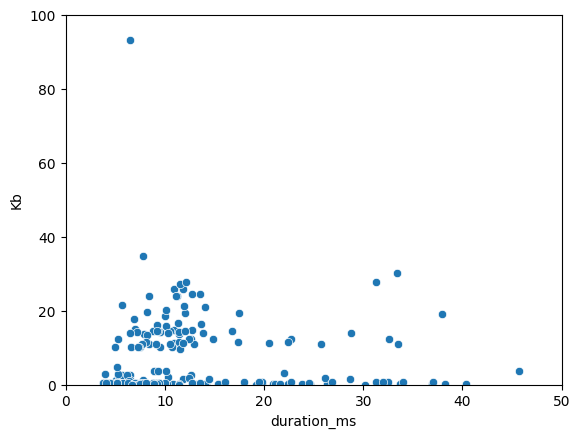

In [319]:
ax = analyze_report(df_ceph_direct_read)
ax.set_ylim(0,100)
ax.set_xlim(0,50)

### WRITE

Number of accesses = 742

Average Throughput = 0.289264397574124 mb/s
Average access duration = 75.80094070080862 ms
Average access size = 55.13256873315364 Kb

Median Throughput = 0.0226285 mb/s
Median access duration = 55.68000000000001 ms
Median access size = 1.446 Kb

IQR Throughput = 0.201548 mb/s
IQR access duration = 48.45375 ms
IQR access size = 8.66 Kb



(0.0, 200.0)

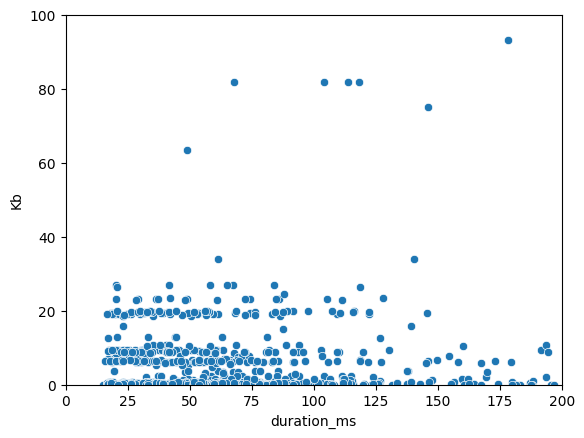

In [302]:
ax = analyze_report(df_ceph_direct_write)
ax.set_ylim(0,100)
ax.set_xlim(0,200)

## SLSFS Performance over time (weird zig zag pattern)

(1.6726248278348654e+18, 1.6726256540555837e+18)

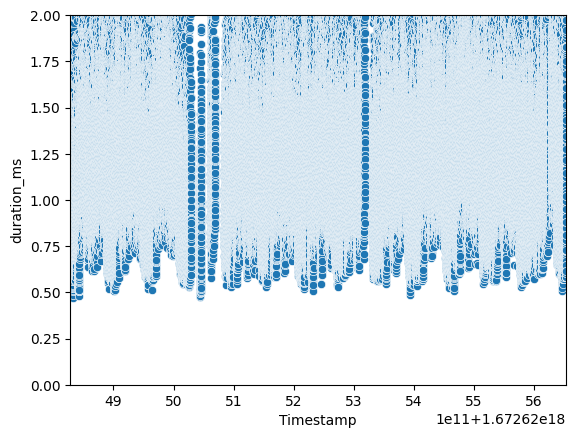

In [201]:
ax = sns.scatterplot(data = df_sls_r_below_1s, 
                     x = df_sls_r_below_1s.Timestamp, 
                     y = df_sls_r_below_1s.duration_ms)
ax.set_ylim(0,2)
## ax.set_xlim(1672624827834865334,1.6726251e+18) ## 5 min window
ax.set_xlim(1672624827834865334,1.6726256540555837e+18) ## mid trace completion

# Scatterplot of individual IO operations, their size, and duration

# Analysis utility

In [9]:
def analyze_report(report):
    ax = sns.scatterplot(data = report, x = report.duration_ms, y = report.Kb)
    average_throughput = report.throughput_mbs.mean()
    average_duration = report.duration_ms.mean()
    average_access_size = report.Kb.mean()
    
    median_throughput = report.throughput_mbs.median()
    median_duration = report.duration_ms.median()
    median_access_size = report.Kb.median()
    
    iqr_throughput = np.subtract(*np.percentile(report.throughput_mbs, [75, 25]))
    iqr_duration = np.subtract(*np.percentile(report.duration_ms, [75, 25]))
    iqr_access_size = np.subtract(*np.percentile(report.Kb, [75, 25]))
    
    print("Number of accesses = {}\n".format(len(report)) )
    
    print("Average Throughput = {} mb/s\nAverage access duration = {} ms\nAverage access size = {} Kb\n".format(
        average_throughput, 
        average_duration, 
        average_access_size))
    print("Median Throughput = {} mb/s\nMedian access duration = {} ms\nMedian access size = {} Kb\n".format(
        median_throughput, 
        median_duration, 
        median_access_size))
    print("IQR Throughput = {} mb/s\nIQR access duration = {} ms\nIQR access size = {} Kb\n".format(
        iqr_throughput, 
        iqr_duration, 
        iqr_access_size))
    return ax

# Caching experiments

# Latency CDF figures

In [127]:
df_caching, df_caching_read, df_caching_write = read_report("caching-reports/trace_emulator_caching/latency_runtime/ssbd_T+cache-xlxky5ax_P+active-load-balance+max-queue+const-time-result/report.csv")

In [128]:
df_no_caching, df_no_caching_read, df_no_caching_write = read_report("caching-reports/trace_emulator_caching/latency_runtime/ssbd_T+nocache-xlxky5ax_P+active-load-balance+max-queue+const-time-result/report.csv")

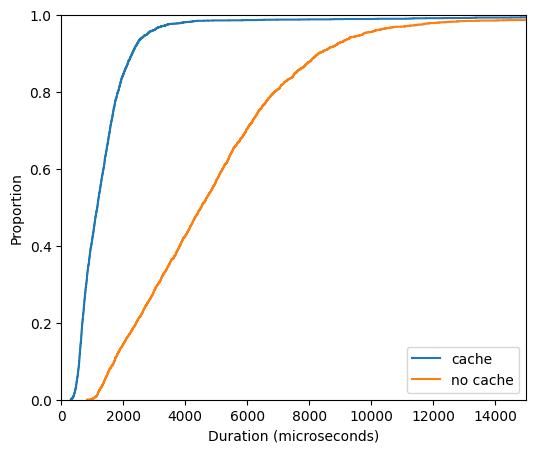

In [132]:
fig, ax = plt.subplots(figsize=(6, 5))

sns.ecdfplot(data=df_caching_read, x="Duration (microseconds)", label="cache", ax=ax)
sns.ecdfplot(data=df_no_caching_read, x="Duration (microseconds)", label="no cache", ax=ax)

ax.legend()

ax.set_xlim(0,15000)
plt.savefig("thesis_figures/latency/xlxky5ax_latency.pdf", format="pdf", bbox_inches="tight")

# Runtime figures

In [150]:
runtime_df = pd.read_csv("caching-reports/trace_emulator_caching/runtime_df.csv")

In [151]:
runtime_df

,workload,runtime,iops,cache,cache hits,cache evicitons,total reads,total writes
0,01qqaww4,1172,625,true,732671,0,732671,0
1,01qqaww4,1535,477,false,0,0,732671,0
2,7xjpt3h0,292,296,true,8,875558,86700,0
3,7xjpt3h0,302,286,false,0,0,86700,0
4,66wi1vut,3,1009,true,2929,0,2929,0
5,66wi1vut,7,436,false,0,0,2929,0
6,7agnu66h,123,49,true,707,304092,1200,4800
7,7agnu66h,112,54,false,0,0,1200,4800
8,j03uywqk,3,848,true,1860,0,1860,1005
9,j03uywqk,4,648,false,0,0,1860,1005


## Runtime 

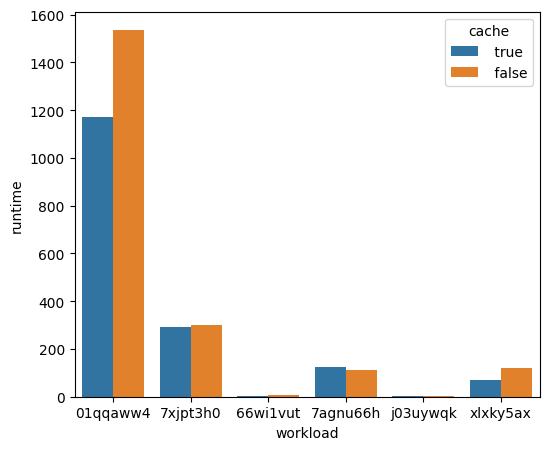

In [190]:
fig, ax = plt.subplots(figsize=(6, 5))

sns.barplot(data=runtime_df, x="workload", y="runtime", hue="cache", ax=ax)

plt.savefig("thesis_figures/runtime//runtime.pdf", format="pdf", bbox_inches="tight")

## Cache hit rate

In [177]:
cache_hit_df = runtime_df[runtime_df["cache"] == " true"]

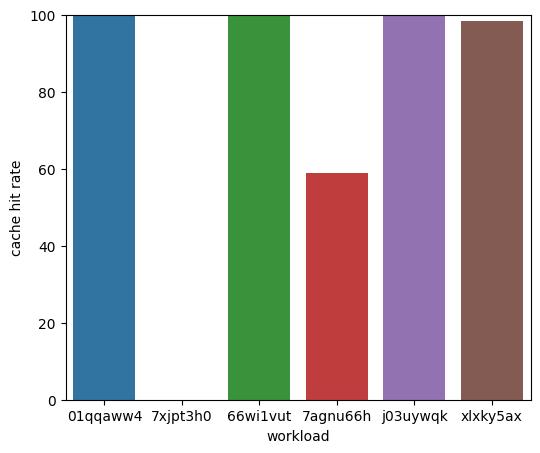

In [206]:
fig, ax = plt.subplots(figsize=(6, 5))

ax = sns.barplot(data=cache_hit_df, x=cache_hit_df["workload"], y=(100 * cache_hit_df["cache hits"] / cache_hit_df["total reads"]), ax=ax)
ax.set_ylabel("cache hit rate")
ax.set_ylim(0,100)

plt.savefig("thesis_figures/runtime/cache_hit_rate.pdf", format="pdf", bbox_inches="tight")

# LRU vs FIFO 7x

## Cache hit rate

In [200]:
policy_df = pd.read_csv("caching-reports/trace_emulator_caching/lru_fifo/df.csv")

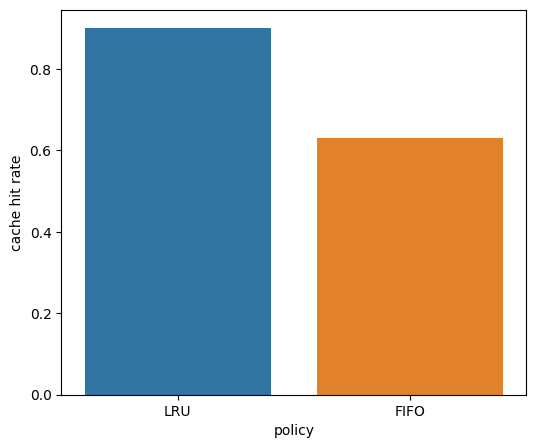

In [201]:
fig, ax = plt.subplots(figsize=(6, 5))

ax = sns.barplot(data=policy_df, x="policy", y="cache hit rate", ax=ax)
ax.set_ylabel("cache hit rate")

plt.savefig("thesis_figures/policy/cache_hit_rate.pdf", format="pdf", bbox_inches="tight")

## Blocks evicted

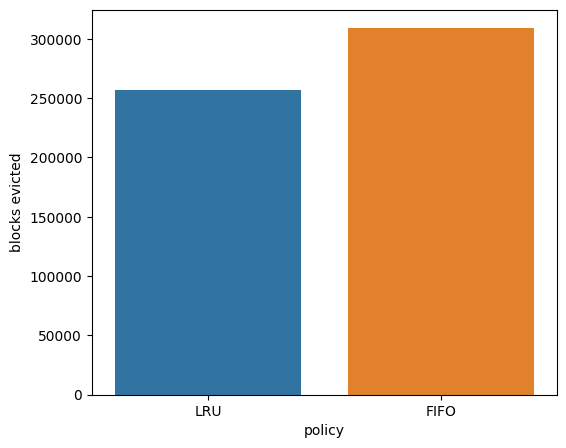

In [203]:
fig, ax = plt.subplots(figsize=(6, 5))

ax = sns.barplot(data=policy_df, x="policy", y="blocks evicted", ax=ax)

plt.savefig("thesis_figures/policy/evictions.pdf", format="pdf", bbox_inches="tight")

# Migration

In [356]:
df_migration, df_migration_read, df_migration_write = read_report("caching-reports/trace_emulator_caching/migra/ssbd_T+cache-migration-66wi1vut-write_P+active-load-balance+max-queue+const-time-result/report.csv")

In [357]:
df_no_migration, df_no_migration_read, df_no_migration_write = read_report("caching-reports/trace_emulator_caching/latency_runtime/ssbd_T+cache-66wi1vut_P+active-load-balance+max-queue+moving-interval-global-result/report.csv")

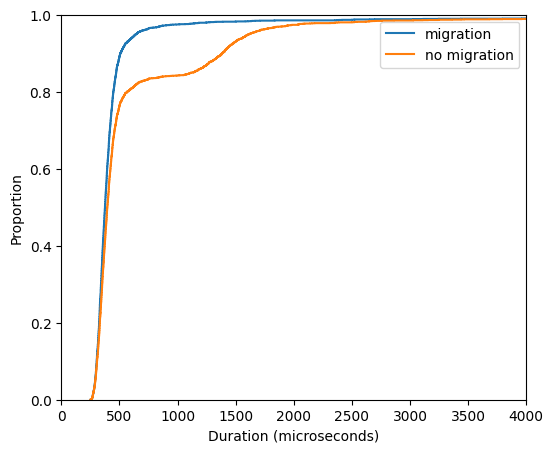

In [358]:
fig, ax = plt.subplots(figsize=(6, 5))

sns.ecdfplot(data=df_no_migration_read, x="Duration (microseconds)", label="migration", ax=ax)
sns.ecdfplot(data=df_migration_read, x="Duration (microseconds)", label="no migration", ax=ax)
ax.set_xlim(0,4000)

ax.legend()

plt.savefig("thesis_figures/migration/latency.pdf", format="pdf", bbox_inches="tight")

# SLFS CDF Caching

MICROSECONDS NOT MS

big writes and reads are very slow with cache due to concatenation

(0.0, 4000.0)

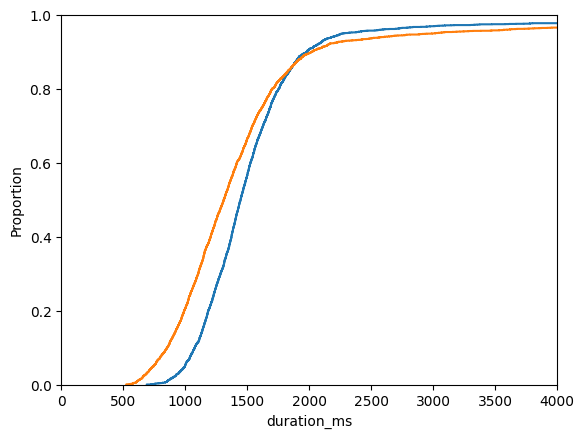

In [21]:
ax = sns.ecdfplot(data=df_caching, x="duration_ms")
sns.ecdfplot(data=df_no_caching, x="duration_ms")
ax.set_xlim(0,4000)

## SLFS No Caching 2 files read trace

Number of accesses = 9092

Average Throughput = 0.007520584799824021 mb/s
Average access duration = 3.191459524857017 ms
Average access size = 0.019000000000000003 Kb

Median Throughput = 0.005931 mb/s
Median access duration = 2.622 ms
Median access size = 0.019 Kb

IQR Throughput = 0.006987500000000001 mb/s
IQR access duration = 1.5050000000000003 ms
IQR access size = 0.018000000000000002 Kb



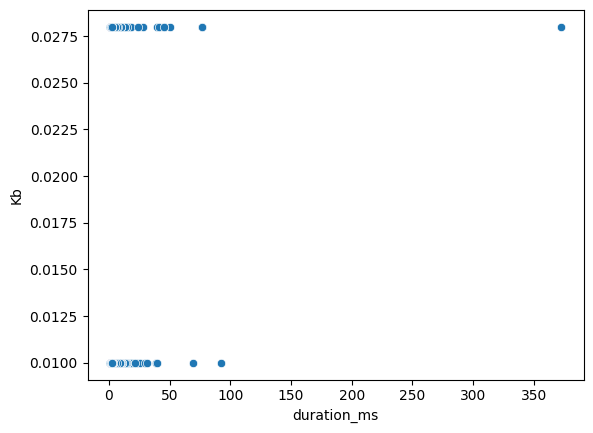

In [11]:
ax = analyze_report(df_no_caching)

## SLFS Caching 2 files read trace

Number of accesses = 9092

Average Throughput = 0.04422847965244171 mb/s
Average access duration = 0.4679049714034317 ms
Average access size = 0.019000000000000003 Kb

Median Throughput = 0.032206 mb/s
Median access duration = 0.421 ms
Median access size = 0.019 Kb

IQR Throughput = 0.04302600000000001 mb/s
IQR access duration = 0.11499999999999999 ms
IQR access size = 0.018000000000000002 Kb



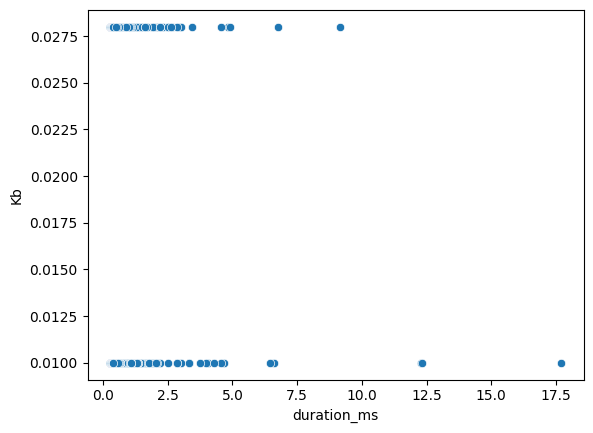

In [12]:
ax = analyze_report(df_caching)

## TEST SAMPLE: SSBD BASIC SLSFS Reads only

Number of accesses = 252

Average Throughput = 1.6824051626984127 mb/s
Average access duration = 3.7432420634920636 ms
Average access size = 19.40227777777778 Kb

Median Throughput = 0.207218 mb/s
Median access duration = 2.5905 ms
Median access size = 0.446 Kb

IQR Throughput = 2.88808125 mb/s
IQR access duration = 1.6972500000000001 ms
IQR access size = 10.956 Kb



(0.0, 20.0)

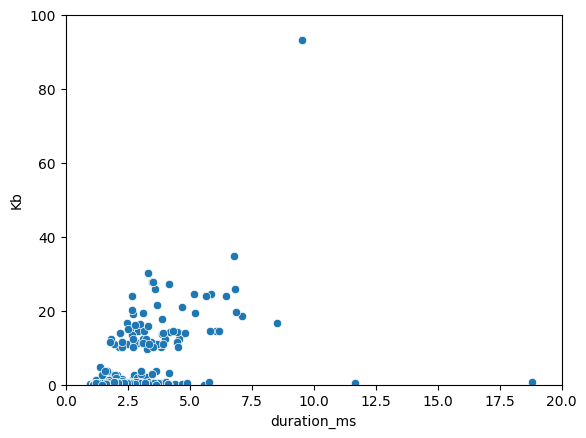

In [294]:
ax = analyze_report(df_sls_ssbd_basic_read)
ax.set_ylim(0,100)
ax.set_xlim(0,20)

## TEST SAMPLE: SSBD BASIC SLSFS Writes only

Number of accesses = 742

Average Throughput = 1.8220128180592994 mb/s
Average access duration = 12.789080862533693 ms
Average access size = 55.13256873315364 Kb

Median Throughput = 0.58667 mb/s
Median access duration = 2.643 ms
Median access size = 1.446 Kb

IQR Throughput = 2.4522127499999997 mb/s
IQR access duration = 2.42725 ms
IQR access size = 8.66 Kb



(0.0, 20.0)

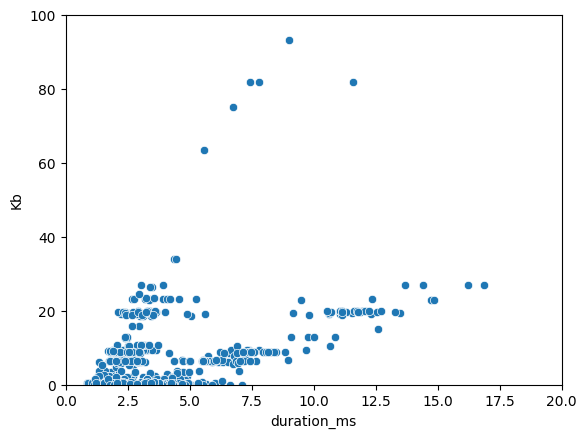

In [295]:
ax = analyze_report(df_sls_ssbd_basic_write)
ax.set_ylim(0,100)
ax.set_xlim(0,20)

## TEST SAMPLE: CEPH 0insggn2 (write only trace)

Number of accesses = 24662

Average Throughput = 0.1643324382450734 mb/s
Average access duration = 76.9549673992377 ms
Average access size = 6.819628983861811 Kb

Median Throughput = 0.027815 mb/s
Median access duration = 42.74 ms
Median access size = 5.885 Kb

IQR Throughput = 0.24238474999999998 mb/s
IQR access duration = 47.85625 ms
IQR access size = 9.153 Kb



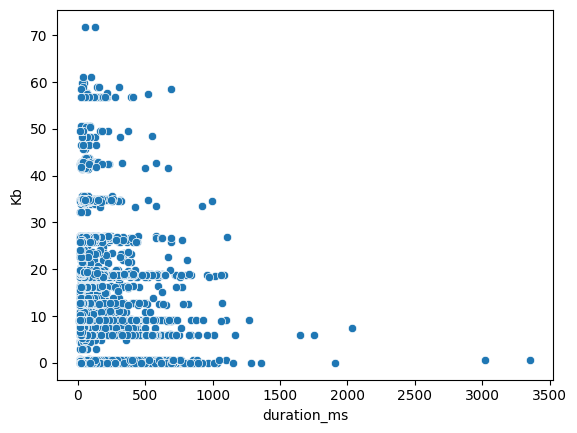

In [296]:
ax = analyze_report(df_ceph_0insggn2)

## SLSFS j2alqt8s

(1.673430461728913e+18, 1.673430613905297e+18)

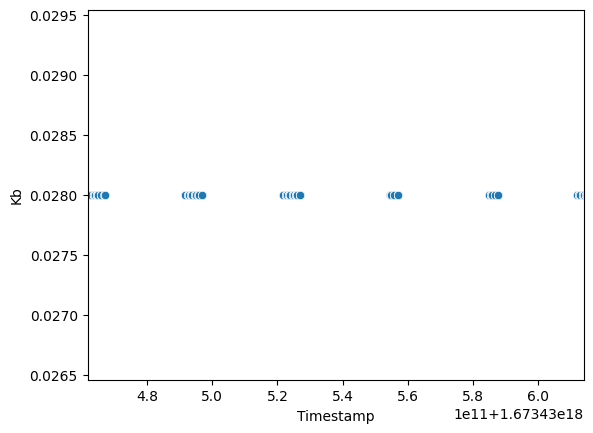

In [360]:
ax = sns.scatterplot(data = df_sls_j2alqt8s_read, x = df_sls_j2alqt8s_read.Timestamp, y = df_sls_j2alqt8s_read.Kb)
ax.set_xlim(1673430461728912971, 1673430613905296947)

## Cold start performance

In [42]:
df_sls_j2alqt8s['Datetime'] = pd.to_datetime(df_sls_j2alqt8s.Timestamp)

In [43]:
df_sls_j2alqt8s['request'] = "request"

In [96]:
df_sls_j2alqt8s.loc[0, 'duration_ms'] = 3234

In [110]:
df_sls_j2alqt8s.loc[67, 'duration_ms'] = 3234

In [109]:
df_sls_j2alqt8s[60:120]

,Timestamp,duration_ms,Kb,access_type,throughput_mbs,Datetime,request
60,1673430466939882578,2.153,0.028,read,0.013005,2023-01-11 09:47:46.939882578,request
61,1673430466944663393,1.774,0.028,read,0.015784,2023-01-11 09:47:46.944663393,request
62,1673430466947346947,1.674,0.028,read,0.016726,2023-01-11 09:47:46.947346947,request
63,1673430466947346947,1.829,0.028,read,0.015309,2023-01-11 09:47:46.947346947,request
64,1673430466949354839,1.332,0.028,read,0.021021,2023-01-11 09:47:46.949354839,request
65,1673430466949354839,1.529,0.028,read,0.018313,2023-01-11 09:47:46.949354839,request
66,1673430466952048060,1.498,0.028,read,0.018692,2023-01-11 09:47:46.952048060,request
67,1673430491737272099,5.517,0.028,read,0.005075,2023-01-11 09:48:11.737272099,request
68,1673430491746226866,2.864,0.028,read,0.009777,2023-01-11 09:48:11.746226866,request
69,1673430492502712670,2.964,0.028,read,0.009447,2023-01-11 09:48:12.502712670,request


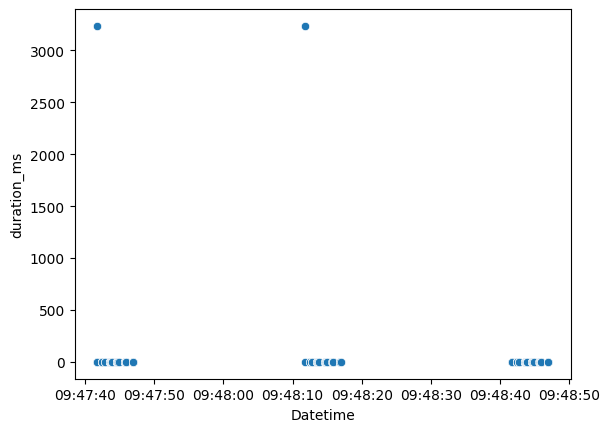

In [112]:
ax = sns.scatterplot(data = df_sls_j2alqt8s[:168], 
                     x = df_sls_j2alqt8s[:168].Datetime, 
                     y = df_sls_j2alqt8s[:168].duration_ms)

fig = ax.get_figure()
fig.savefig("out.png") 

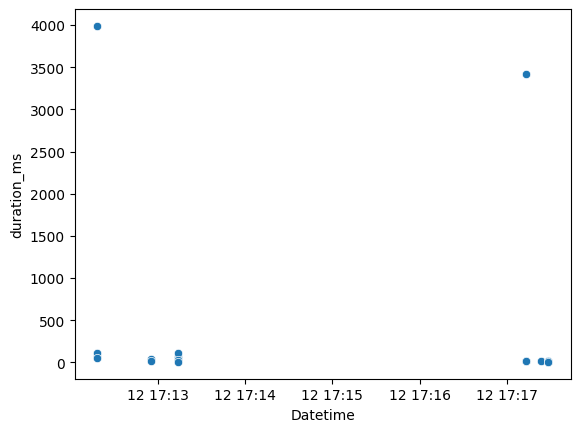

In [39]:
ax = sns.scatterplot(data = df_sls_7a.iloc[11:], x = df_sls_7a.iloc[11:].Datetime, y = df_sls_7a.iloc[11:].duration_ms)

## Report 01qq 12 cold starts

In [3]:
report_01qq_12 = pd.read_csv("exp-reports/report_01qq12hour.csv", delim_whitespace=True)

In [13]:
report_01qq_12

,Datetime,Activation,ID,Kind,Start,Duration,Status,Entity
0,2023-02-21,14:27:32,49a3d7f7814a4c51a3d7f7814a6c5128,blackbox,cold,3m48.783s,success,guest/slsfs-datafunction-0:0.0.50
1,2023-02-21,12:44:59,504ebfaf6cef441b8ebfaf6cefa41b8b,blackbox,warm,2m7.294s,success,guest/slsfs-datafunction-0:0.0.49
2,2023-02-21,12:39:59,215a6422d5b743a69a6422d5b7b3a644,blackbox,warm,4m58.018s,success,guest/slsfs-datafunction-0:0.0.49
3,2023-02-21,12:34:59,cff61aafb1894441b61aafb189b44182,blackbox,warm,4m58.024s,success,guest/slsfs-datafunction-0:0.0.49
4,2023-02-21,12:29:59,584eac2b39224c578eac2b3922dc576a,blackbox,warm,4m58.018s,success,guest/slsfs-datafunction-0:0.0.49
...,...,...,...,...,...,...,...,...
143,2023-02-21,00:55:58,6732daa5989d43a0b2daa5989d93a05d,blackbox,warm,4m58.027s,success,guest/slsfs-datafunction-0:0.0.49
144,2023-02-21,00:51:00,e5da3da686ed46439a3da686ed66435b,blackbox,warm,4m58.019s,success,guest/slsfs-datafunction-0:0.0.49
145,2023-02-21,00:46:00,51b20afeabb04eccb20afeabb00ecca0,blackbox,cold,4m58.459s,success,guest/slsfs-datafunction-0:0.0.49
146,2023-02-21,00:18:49,3ce03cd03ad147d7a03cd03ad107d75c,blackbox,cold,3m34.908s,success,guest/slsfs-datafunction-0:0.0.48


In [12]:
report_01qq_12[report_01qq_12['Start'] == "warm"].count()

Datetime      138
Activation    138
ID            138
Kind          138
Start         138
Duration      138
Status        138
Entity        138
dtype: int64